In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.streaming import StreamingContext

In [2]:
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display
import time
import os, shutil

In [3]:
conf = SparkConf()
conf.setAppName("HotAlgorithms")
conf.setMaster("spark://192.168.0.108:7077")

In [4]:
sc.stop()
sc = SparkContext(conf = conf)
wait_time = 1
ssc = StreamingContext(sc, wait_time)

# checkpoint 由于使用updateStateByKey(),需要提供检查点以缓存之前批次的中间结果

# 检查点路径
checkpoint_dir_path = "checkpoint"
# remove file
def del_file(checkpoint_dir_path):
    ls = os.listdir(checkpoint_dir_path)
    for i in ls:
        file_path = os.path.join(checkpoint_dir_path, i)
        if os.path.isfile(file_path):
            os.remove(file_path)
        else:
            shutil.rmtree(file_path, True)        

del_file(checkpoint_dir_path)

ssc.checkpoint(checkpoint_dir_path)

In [5]:
# spark 监视目录
text_file_path = "outputDir"
lines = ssc.textFileStream(text_file_path)
words = lines.flatMap(lambda line: line.split(';'))
words = words.filter(lambda x: x != "null")

# 做map并把之前计算的内容累加
def updateFunction(newValues,runningCount):
    if runningCount is None:
        runningCount = 0
    return sum(newValues,runningCount) #add the new values with the previous running count to get the new count

runningCounts = words.map(lambda x:(x,1)).updateStateByKey(updateFunction)


In [6]:
# 使用foreachRDD 输出模式， 显示为柱状图

def output_histogram(time, RDD):
    show_num = 10
    RDD = RDD.sortBy(ascending = False, numPartitions = None, keyfunc = lambda x: x[1])
    taken = RDD.take(show_num)
    
    if len(taken) == 0:
        return
    
    algorithms = np.array([x[0] for x in taken])
    frequency = np.array([x[1] for x in taken])
    
 
    plt.rcParams['axes.unicode_minus']=False
    plt.rcParams['figure.figsize'] = [20, 15]
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x()+rect.get_width()/2.-0.25, 1.01*height, '%s' % int(height))
        
    plt.xticks(np.arange(len(algorithms)), algorithms)
    rects = plt.bar(np.arange(len(frequency)), frequency, color=['r','g','b', 'c', 'm', 'y'])
    autolabel(rects)
    
    plt.title("Hot Algorithms: Top 10", fontsize=20)
    plt.ylabel('Frequency', fontsize=16) 
    plt.xlabel('Algotithms',fontsize=16) 
    plt.show()
    display.clear_output(wait=True)

In [7]:
# 使用foreachRDD 输出模式， 显示为圆饼图

def output_pieChart(time, RDD):
    show_num = 10
    RDD = RDD.sortBy(ascending = False, numPartitions = None, keyfunc = lambda x: x[1])
    taken = RDD.take(show_num)
    
    if len(taken) == 0:
        return
    
    algorithms = np.array([x[0] for x in taken])
    frequency = np.array([x[1] for x in taken])
    
 
    plt.rcParams['axes.unicode_minus']=False
    plt.rcParams['figure.figsize'] = [20, 10]
    
    explode = (0,0,0,0,0,0,0,0,0,0)
    colors=['deeppink','orchid','indigo', 'royalblue', 'slategray', 'cyan', 'springgreen','yellow','orange','tomato']

    patches,l_text,p_text = plt.pie(frequency,
                                    explode=explode,
                                    labels=algorithms,
                                    colors=colors,
                                    labeldistance = 1.05,
                                    autopct = '%3.1f%%',
                                    shadow = False,
                                    startangle = 90,
                                    pctdistance = 0.6)
    
    
    plt.title("Hot Algorithms: Top 10", fontsize=20)
    plt.axis('equal')
    plt.legend()
    plt.show()
    
    display.clear_output(wait=True)

In [7]:
# 输出为柱状图
runningCounts.foreachRDD(output_histogram)

# 输出为圆饼图
# runningCounts.foreachRDD(output_pieChart)

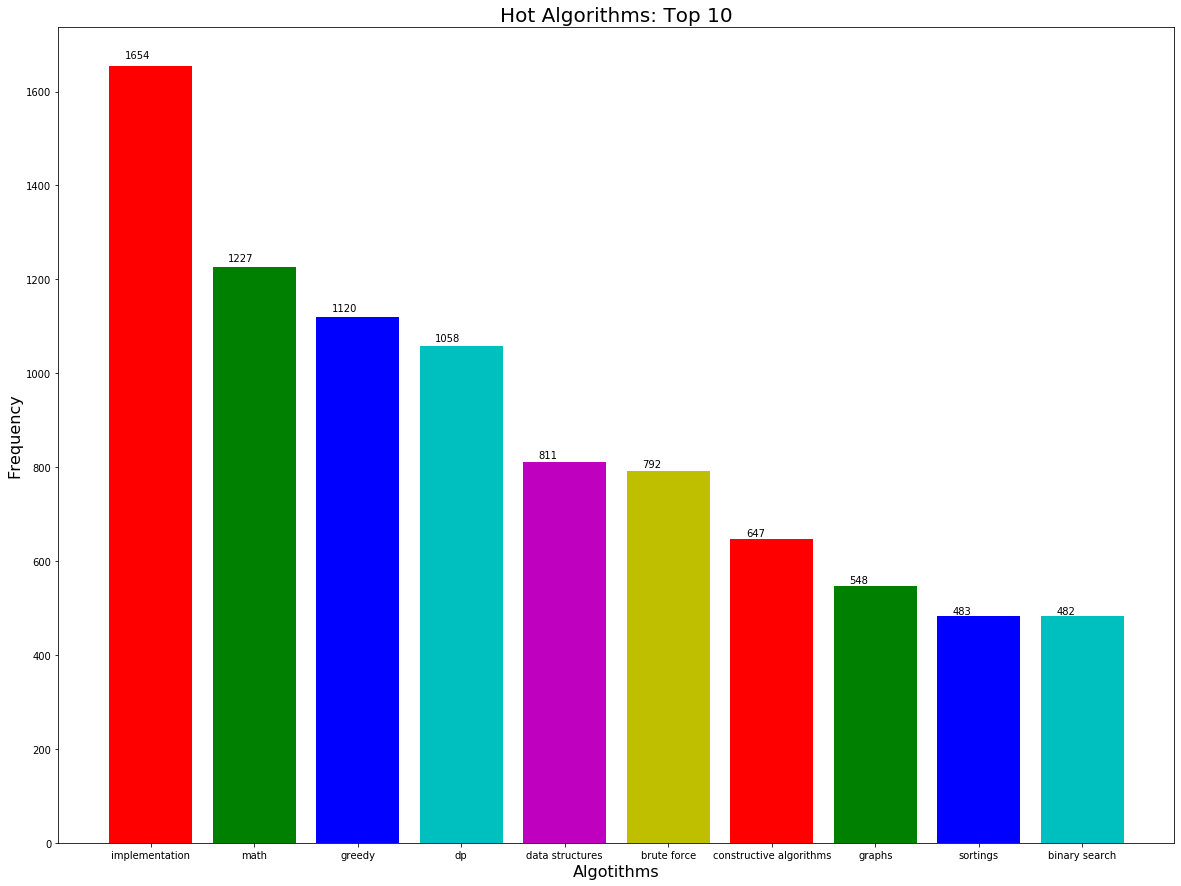

In [8]:
ssc.start()  